In [1]:
from helpers.utilities import *
%run helpers/notebook_setup.ipynb

In [2]:
%R source('plots/colors.R');

In [3]:
clinical_deseq2_path = 'data/clean/rna/clinical_data_ordered_to_match_rna_deseq2.csv'

# normalized counts
deseq2_path = 'data/clean/rna/all_samples.csv'

In [4]:
clinical_deseq2 = read_csv(clinical_deseq2_path, index_col=0)

raw_deseq2_matrix = read_csv(deseq2_path, index_col=[0, 1])

In [5]:
raw_deseq2_matrix = raw_deseq2_matrix.reset_index()

index_columns = raw_deseq2_matrix[['ensembl_id', 'ensembl_gene_id']]

raw_deseq2_matrix = raw_deseq2_matrix.drop(columns=['ensembl_gene_id']).set_index('ensembl_id')

In [6]:
by_condition = clinical_deseq2.Meningitis

## Sanity checks:

In [7]:
assert not index_columns.ensembl_id.duplicated().any()

In [8]:
index_columns.ensembl_id.head()

0    ENSG00000000003
1    ENSG00000000005
2    ENSG00000000419
3    ENSG00000000457
4    ENSG00000000460
Name: ensembl_id, dtype: object

However:

In [9]:
index_columns.ensembl_gene_id.duplicated().any()

True

Interesting... These are not isoforms but have duplicates:

In [10]:
duplicated = index_columns[index_columns.ensembl_gene_id.duplicated(keep=False)].sort_values('ensembl_gene_id')
duplicated

,ensembl_id,ensembl_gene_id
8573,ENSG00000145416,36951
15840,ENSG00000186205,36951
2089,ENSG00000099785,37316
4707,ENSG00000117791,37316
28327,ENSG00000249738,AC008691.1
...,...,...
22243,ENSG00000228741,SPATA13
10056,ENSG00000158427,TMSB15B
34348,ENSG00000269226,TMSB15B
35935,ENSG00000273768,U1


Pseudo-autosomal regions? Or just a redundant set?

In [11]:
from pyensembl import EnsemblRelease

ensembl = EnsemblRelease(95)

In [12]:
from helpers.utilities import get_or_dummy, dummy

def get_gene(gene_id):
    return get_or_dummy(ensembl.gene_by_id, gene_id)

In [13]:
duplicated_genes = duplicated.ensembl_id.apply(get_gene)

Failed to map:

In [14]:
missing = duplicated[duplicated_genes == dummy]
show_table(missing)

,ensembl_id,ensembl_gene_id
29552,ENSG00000254199,AC008691.1
38510,ENSG00000283406,DGCR5
34184,ENSG00000268439,EMG1
26894,ENSG00000242150,RPS10P7


The sex chromosomes do not appear to be enriched:

In [15]:
show_table(
    duplicated_genes.apply(lambda gene: gene.contig).value_counts().to_frame().T
)

,1,2,22,7,10,21,3,5,12,17,16,9,X,4,8,13,19,KI270713.1,15,14
ensembl_id,8,7,7,5,5,4,4,4,4,3,3,3,3,2,2,2,2,1,1,1


In [16]:
not_missing = duplicated_genes[~duplicated.ensembl_gene_id.isin(missing.ensembl_gene_id)]

gene_data = DataFrame(not_missing.apply(lambda g: g.__dict__).to_list()).drop(['db', 'genome'], axis=1)

In [17]:
show_table(gene_data)

,contig,strand,start,end,biotype,gene_id,gene_name
0,4,-,163524298,164384050,protein_coding,ENSG00000145416,MARCH1
1,1,+,220786759,220819657,protein_coding,ENSG00000186205,MARC1
2,19,+,8413270,8439017,protein_coding,ENSG00000099785,MARCH2
3,1,+,220748225,220784815,protein_coding,ENSG00000117791,MARC2
4,2,+,91940668,91942040,processed_pseudogene,ENSG00000226481,ACTR3BP2
...,...,...,...,...,...,...,...
62,13,+,23979810,24035027,lincRNA,ENSG00000228741,SPATA13
63,X,+,103918896,103966712,protein_coding,ENSG00000158427,TMSB15B
64,X,-,104063871,104076212,protein_coding,ENSG00000269226,TMSB15B
65,1,+,146376807,146376970,snRNA,ENSG00000273768,RF00003


In [18]:
gene_data.biotype.value_counts()

protein_coding                        23
misc_RNA                              17
lincRNA                               10
antisense                              6
processed_transcript                   2
transcribed_unprocessed_pseudogene     2
snRNA                                  2
processed_pseudogene                   2
rRNA                                   2
sense_overlapping                      1
Name: biotype, dtype: int64

Copies on different chromosomes:

In [19]:
gene_data.groupby('gene_name').filter(lambda genes: len(set(genes.contig)) > 1)

,contig,strand,start,end,biotype,gene_id,gene_name
4,2,+,91940668,91942040,processed_pseudogene,ENSG00000226481,ACTR3BP2
5,22,+,16486985,16488322,processed_pseudogene,ENSG00000280263,ACTR3BP2
26,22,+,15746630,15778297,lincRNA,ENSG00000225255,LINC01297
27,14,-,19344578,19384587,lincRNA,ENSG00000274827,LINC01297
32,2,+,201097744,201098091,misc_RNA,ENSG00000273975,RF00017
...,...,...,...,...,...,...,...
46,1,+,29041199,29041480,misc_RNA,ENSG00000277958,RF00017
47,16,+,4658851,4659151,misc_RNA,ENSG00000278700,RF00017
48,17,-,45526466,45526746,misc_RNA,ENSG00000278770,RF00017
65,1,+,146376807,146376970,snRNA,ENSG00000273768,RF00003


Conclusions
 - many non-protein coding genes (30+/67)
 - sometimes just a copy on another chromosome (23/67)
 - duplication due to alternative ORFs?

## Closer look at the values

In [20]:
raw_deseq2_matrix.head()

,001.TMD,006.CM,012.BM,016.CM,017.TMD,...,174.CM,011.TMR,043.TMS,078.CM,261.CM
ensembl_id,,,,,,,,,,,
ENSG00000000003,11.596119,7.806308,1.391555,39.347366,24.765008,...,4.431071,51.810470,35.628629,0.000000,20.705553
ENSG00000000005,0.000000,0.000000,0.000000,2.459210,0.000000,...,0.000000,11.102244,0.000000,0.000000,4.141111
ENSG00000000419,0.000000,31.225230,36.876198,0.000000,72.313823,...,25.478656,11.102244,0.000000,161.520987,39.754662
ENSG00000000457,127.557309,145.717740,86.276387,95.909204,123.825040,...,121.854440,96.219444,3.958737,92.395480,125.889763
ENSG00000000460,46.384476,0.000000,50.791744,51.643418,14.859005,...,33.233029,49.960096,38.267787,0.000000,30.644219


In [21]:
stacked = raw_deseq2_matrix.melt(var_name='patient', value_name='normalised_count')

In [22]:
from plots.annotations import tuberculosis_status

In [23]:
stacked['group'] = stacked.patient.map(by_condition)
stacked['TB_status'] = stacked.patient.apply(lambda patient: patient.split('.')[1]).map(tuberculosis_status).fillna('-')

In [24]:
stacked.head()

,patient,normalised_count,group,TB_status
0,001.TMD,11.596119,Tuberculosis,Definite
1,001.TMD,0.000000,Tuberculosis,Definite
2,001.TMD,0.000000,Tuberculosis,Definite
3,001.TMD,127.557309,Tuberculosis,Definite
4,001.TMD,46.384476,Tuberculosis,Definite


In [25]:
%R -i stacked

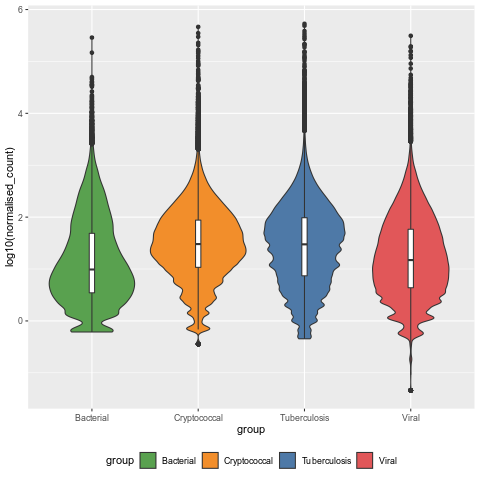

In [26]:
%%R
(
    ggplot(stacked, aes(x=group, y=log10(normalised_count), fill=group))
    + geom_violin()
    + geom_boxplot(fill='white', width=.05)
    + scale_fill_manual(values=patient_colors$Meningitis)
    + theme(legend.position='bottom')
)

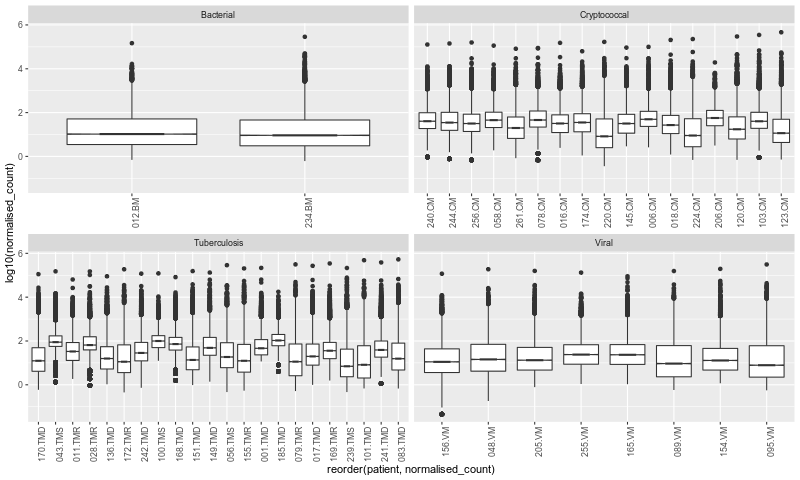

In [27]:
%%R -w 800
(
    ggplot(stacked, aes(x=reorder(patient, normalised_count), y=log10(normalised_count)))
    + facet_wrap('~ group', scale='free_x')
    + geom_boxplot(notch=T)
    + theme(axis.text.x = element_text(angle = 90))
)

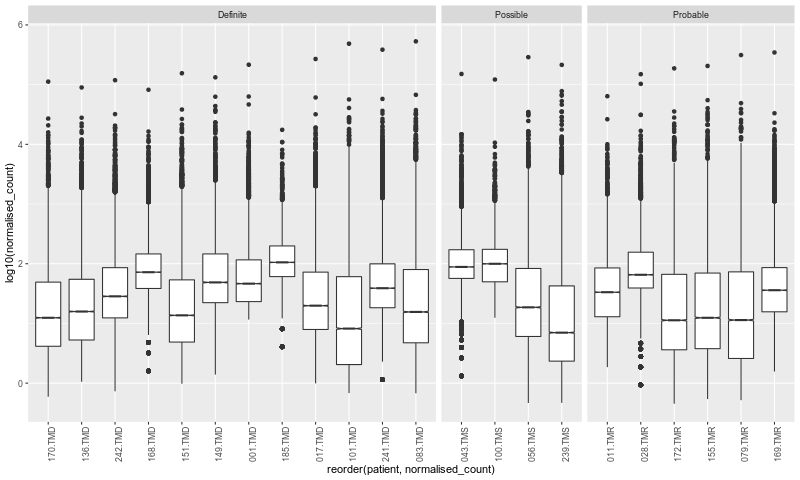

In [28]:
%%R -w 800
(
    ggplot(
        stacked[stacked$group == 'Tuberculosis', ],
        aes(x=reorder(patient, normalised_count), y=log10(normalised_count))
    )
    + facet_grid('~ TB_status', scale='free_x', space='free_x')
    + geom_boxplot(notch=T)
    + scale_fill_manual(values=patient_colors$Meningitis)
    + theme(axis.text.x = element_text(angle = 90))
)

Note: These are already normalised (DESeq2) counts.